# Model fitting with `cluster-lensing` & `emcee`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from clusterlensing import ClusterEnsemble

import emcee
import corner

% matplotlib inline

In [6]:
import matplotlib
matplotlib.rcParams["axes.labelsize"] = 20
matplotlib.rcParams["legend.fontsize"] = 12

## Generate a noisy measurement to fit

In [3]:
logm_true = 14
off_true = 0.3

nbins = 10

redshifts = [0.2]
mass = [10**logm_true]
offsets = [off_true]
rbins = np.logspace(np.log10(0.1), np.log10(5), num = nbins)

cdata = ClusterEnsemble(redshifts)
cdata.m200 = mass
cdata.calc_nfw(rbins=rbins, offsets=offsets)
dsigma_true = cdata.deltasigma_nfw.mean(axis=0).value

# add scatter with a stddev of 20% of data
noise = np.random.normal(scale=dsigma_true*0.2, size=nbins)
y = dsigma_true + noise
yerr = np.abs(dsigma_true/3)  # 33% error bars

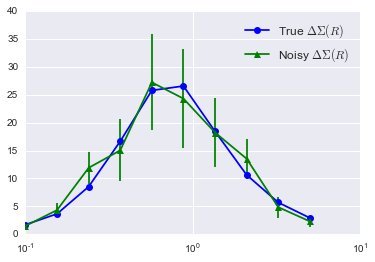

In [7]:
plt.plot(rbins, dsigma_true, 'bo-', label='True $\Delta\Sigma(R)$')
plt.plot(rbins, y, 'g^-', label='Noisy $\Delta\Sigma(R)$')
plt.errorbar(rbins, y, yerr=yerr, color='g', linestyle='None')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

## Write down likelihood, prior, and posterior probilities
The model parameters are the mass and centroid offsets. Redshift is assumed to be known.

In [8]:
# probability of the data given the model
def lnlike(theta, z, rbins, data, stddev):
    logm, offsets = theta
    
    # calculate the model
    c = ClusterEnsemble(z)
    c.m200 = [10 ** logm]
    c.calc_nfw(rbins=rbins, offsets=[offsets])
    model = c.deltasigma_nfw.mean(axis=0).value
    
    diff = data - model
    lnlikelihood = -0.5 * np.sum(diff**2 / stddev**2)
    return lnlikelihood

# uninformative prior
def lnprior(theta):
    logm, offset = theta
    if 10 < logm < 16 and 0.0 <= offset < 5.0:
        return 0.0
    else:
        return -np.inf

# posterior probability
def lnprob(theta, z, rbins, data, stddev):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, z, rbins, data, stddev)

### Sample the posterior using `emcee`

In [9]:
ndim = 2
nwalkers = 20
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
p0[:,0] = p0[:,0] + 13.5  # start somewhere close to true logm ~ 14

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(redshifts, rbins, y, yerr), threads=8)

In [21]:
# the MCMC chains take some time: about 49 minutes for the 500 samples below
i_can_wait = False  # or can you? Set to True to run the MCMC chains

if i_can_wait:
    pos, prob, state = sampler.run_mcmc(p0, 500)

### Check walker positions for burn-in

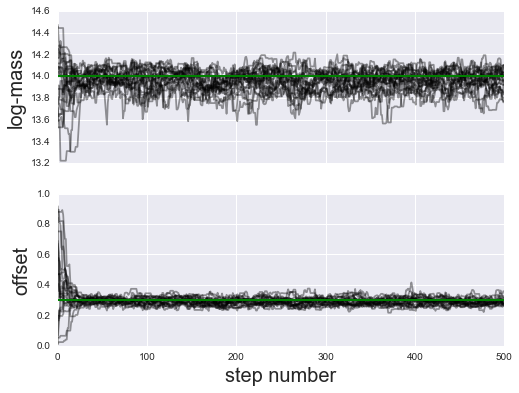

In [14]:
if i_can_wait:
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
    axes[0].axhline(logm_true, color="g", lw=2)
    axes[0].set_ylabel("log-mass")

    axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
    axes[1].axhline(off_true, color="g", lw=2)
    axes[1].set_ylabel("offset")
    axes[1].set_xlabel("step number")

## Model parameter results

In [22]:
if i_can_wait:
    burn_in_step = 50  # based on a rough look at the walker positions above
    samples = sampler.chain[:, burn_in_step:, :].reshape((-1, ndim))

else:
    # read in a previously generated chain
    samples = np.loadtxt('samples.txt')

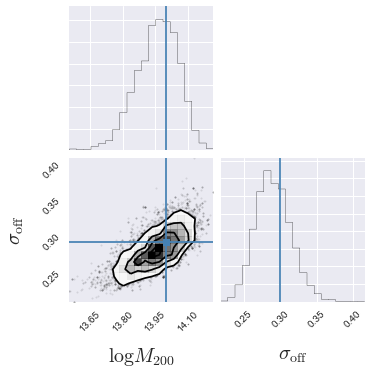

In [23]:
fig = corner.corner(samples,
                    labels=["$\mathrm{log}M_{200}$", "$\sigma_\mathrm{off}$"],
                    truths=[logm_true, off_true])
fig.savefig('cornerplot.png')

In [20]:
# save the chain for later
np.savetxt('samples.txt', samples)